In [1]:

#Chargement des biblioth_ques
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency

In [6]:
# repertoire (relatif) des ficheirs de données
data_path = '../../Data'


In [8]:
#chargement des nomenclatures

#libelles : correspodnance valeur de la variable avec le libelle correspond
libelles = pd.read_csv('{}/libelles.csv'.format(data_path), sep=';', index_col=['colonne', 'indice'])

#variable : libelle complet pour chaque variable
variables = pd.read_csv('{}/variables.csv'.format(data_path), sep=';', index_col = ['variable'])


In [12]:
#chargement des données
annees = [str(x) for x in np.arange(2019,2023)]

carac = pd.DataFrame()
lieux = pd.DataFrame()
usagers = pd.DataFrame()
vehicules = pd.DataFrame()
for annee in annees : 
    carac = pd.concat([carac, pd.read_csv("{}/caracteristiques-{}.csv".format(data_path, annee), sep=';', dtype=object)])
    lieux = pd.concat([lieux, pd.read_csv("{}/lieux-{}.csv".format(data_path, annee), sep=';', dtype=object)])
    usagers = pd.concat([usagers, pd.read_csv("{}/usagers-{}.csv".format(data_path, annee), dtype=object,sep=';')])
    vehicules = pd.concat([vehicules, pd.read_csv("{}/vehicules-{}.csv".format(data_path, annee), sep=';', dtype=object)])


In [13]:
#correction identifiant accident
carac['Num_Acc'] = carac['Num_Acc'].fillna(carac['Accident_Id'])
carac = carac.drop('Accident_Id', axis = 1)

#jointure carac-lieux
df = pd.merge(left = carac, right = lieux, left_on = 'Num_Acc', right_on='Num_Acc')

#jointure df-vehicules
df = pd.merge(left=df, right=vehicules, left_on='Num_Acc', right_on='Num_Acc')

#jointure df-usagers
df = pd.merge(left=df, right=usagers, right_on='id_vehicule', left_on='id_vehicule')

#suppression des identifiants
df = df.drop(['Num_Acc_x', 'id_vehicule', 'num_veh_x', 'Num_Acc_y','num_veh_y', 'id_usager'], axis = 1)

In [14]:
#recodage dess données manquantes en nan
df = df.replace({
    '-1':np.nan,
    -1:np.nan,
    ' -1':np.nan,
    '#ERREUR':np.nan
})



In [15]:
#secu  : un champ binaire par équipement
for i in range(1,10) :
    df['secu_'+str(i)] = ((df['secu1']==i) | (df['secu2']==i) | (df['secu3']==i))*1

df = df.drop(['secu1','secu2','secu3'], axis = 1)

In [16]:
pd.DataFrame({'column_name': df.columns,'percent_missing': df.isnull().sum() * 100 / len(df)}).sort_values('percent_missing', ascending=False).head(5)


,column_name,percent_missing
lartpc,lartpc,99.781052
occutc,occutc,98.742973
larrout,larrout,95.380649
etatp,etatp,92.323476
v2,v2,91.998494


In [17]:
#elimination des colonnes avec plus de 25% de valeurs manquantes
df = df.dropna(thresh=len(df)*3/4, axis = 1)

In [18]:
#suppression des lignes sans variable d'Interet
df = df.dropna(subset=['grav'])

In [19]:
# suppression de l'adresse qui ne sert à rien
df = df.drop('adr', axis = 1)

In [20]:
#suppression des variables de dénomination des voies ininterprétables
df = df.drop(['voie','v1'], axis = 1)

In [21]:
df.isna().sum(axis = 1).sum()/len(df)

0.1438342434716055

In [22]:
#suppression des lignes ayant au mojns une valeur nulle (#14%)
df = df.dropna(how = 'any', axis=0)

In [23]:
#restent 442989 lignes
df.shape

(442989, 47)

In [24]:
#conversion des latitudes et longitudes
df['lat']= df['lat'].str.replace(',','.').astype('float')
df['long']= df['long'].str.replace(',','.').astype('float')


In [25]:
#on ajoute un créneau horaire
df['hh'] = df['hrmn'].str[:2]

df = df.drop('hrmn', axis = 1)

In [26]:
#conversion en entier
df['hh'] = df['hh'].astype('int')

In [27]:
#on ajoute une variablme binaire indiquant semaine ou weekend
df['weekend']=(pd.to_datetime(dict(day=df['jour'], month=df['mois'], year=df['an'])).dt.weekday>=5)*1

In [28]:
#calcul de l'age des usagers dans l'année de l'accident
df['age'] = df['an'].astype(int) - df['an_nais'].astype(int)

df = df.drop('an_nais', axis = 1)

In [29]:
#suppression des jours et années
df = df.drop(['jour','an'], axis = 1)

In [30]:
# suppression des varaible de localisation (on utilsaera la géolocalisation) et des varaibles diffficilement interprétabes
df = df.drop(['pr','pr1', 'senc', 'dep','com'], axis = 1)

In [31]:
df.shape

(442989, 41)

In [32]:
# Conversion des variables catégorielles en entiers
df[['lum', 'int', 'atm', 'col',  'circ', 'vosp', 'prof',
       'plan', 'surf', 'infra', 'situ', 'vma', 'catv', 'obs', 'obsm', 'choc',
       'manv', 'motor', 'place', 'grav', 'sexe', 'trajet','nbv']] = df[['lum', 'int', 'atm', 'col',  'circ', 'vosp', 'prof',
       'plan', 'surf', 'infra', 'situ', 'vma', 'catv', 'obs', 'obsm', 'choc',
       'manv', 'motor', 'place', 'grav', 'sexe', 'trajet','nbv']].astype('int')

In [33]:
#recodage de la gravité : indice croissant
"""
Av => apr => label
1 => 0 => Indemme
4 => 1 => Blessé léger
3 => 2 => Blessé hospitalisé
2 => 3 => Tué
"""

df['grav']=df['grav'].replace({1:0})
df['grav']=df['grav'].replace({4:1})

df['grav']=df['grav'].replace({3:5})
df['grav']=df['grav'].replace({2:3})
df['grav']=df['grav'].replace({5:2})

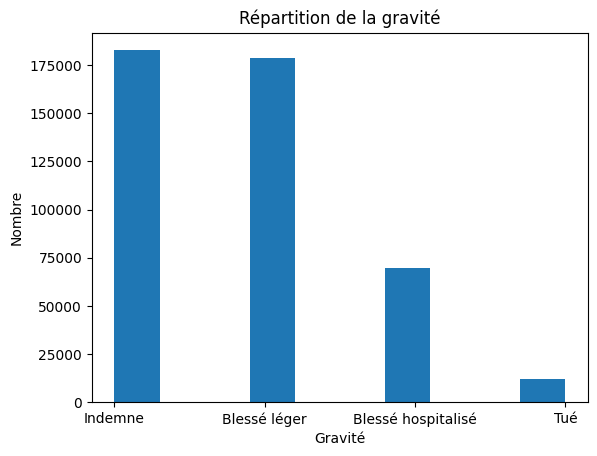

In [35]:
gravite = ['Indemne','Blessé léger', 'Blessé hospitalisé', 'Tué',]

df['grav'].astype('str').sort_values().hist(grid=False)
plt.title('Répartition de la gravité')
plt.ylabel('Nombre')
plt.xlabel('Gravité')
plt.xticks(ticks=['0','1','2','3'],labels=gravite);

In [36]:
for v in df.select_dtypes('int').columns :
    cont = pd.crosstab(df[v], df['grav'])
    print(v , chi2_contingency(cont).pvalue)
    

lum 0.0
int 0.0
atm 7.916281360525653e-306
col 0.0
circ 0.0
nbv 0.0
vosp 8.151900559932659e-258
prof 0.0
plan 0.0
surf 1.5559956127296118e-174
infra 5.910429278433572e-197
situ 0.0
vma 0.0
catv 0.0
obs 0.0
obsm 0.0
choc 0.0
manv 0.0
motor 0.0
place 0.0
grav 0.0
sexe 0.0
trajet 0.0
secu_1 1.0
secu_2 1.0
secu_3 1.0
secu_4 1.0
secu_5 1.0
secu_6 1.0
secu_7 1.0
secu_8 1.0
secu_9 1.0
hh 0.0
weekend 1.311599964330357e-226
age 0.0


In [49]:
df.groupby('age').agg(tues = ('grav', lambda x : x.sum() if x==3 else 0 ))

ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

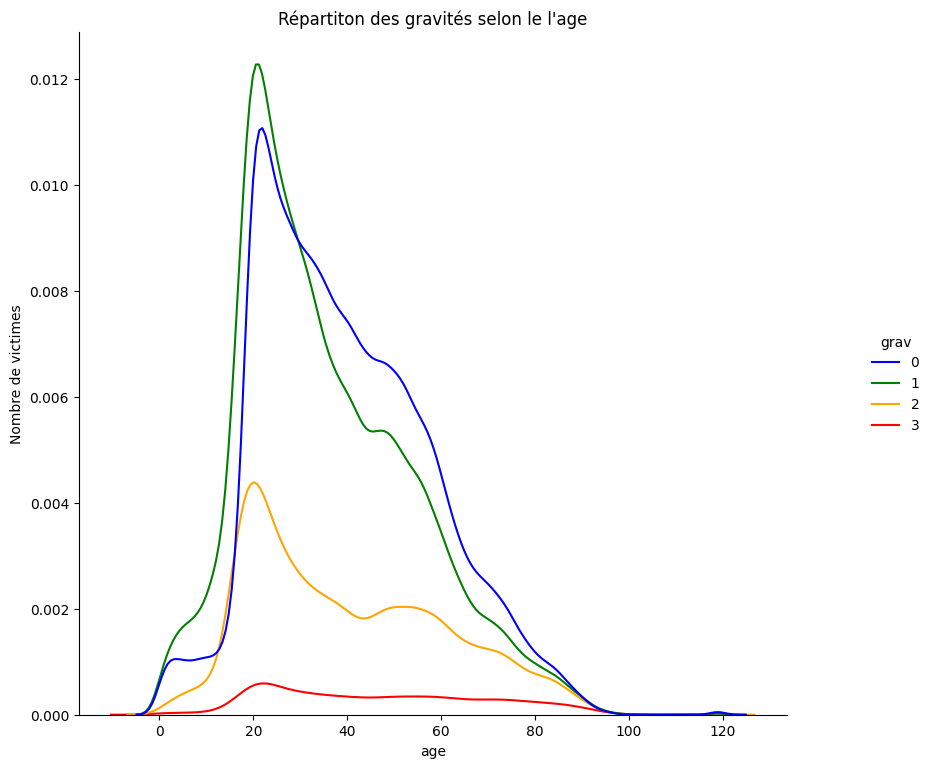

In [44]:
#weeknd

sns.color_palette("Paired")
palette = ['blue','green', 'orange','red']
        
g = sns.displot(data=df, x='age',  hue='grav', palette=palette, multiple='layer', kind = 'kde')
g.figure.set_size_inches(10,8)
plt.ylabel('Nombre de victimes')
plt.title('Répartiton des gravités selon le l\'age');

In [41]:
bins = [0,10,18,25,45,65,999]
labels=[0,1,2,3,4,5,6]
df['classe_age'] = pd.cut(df['age'], bins=bins, labels=labels, include_lowest=True)

ValueError: Bin labels must be one fewer than the number of bin edges

In [84]:
df = df.drop('age', axis = 1)

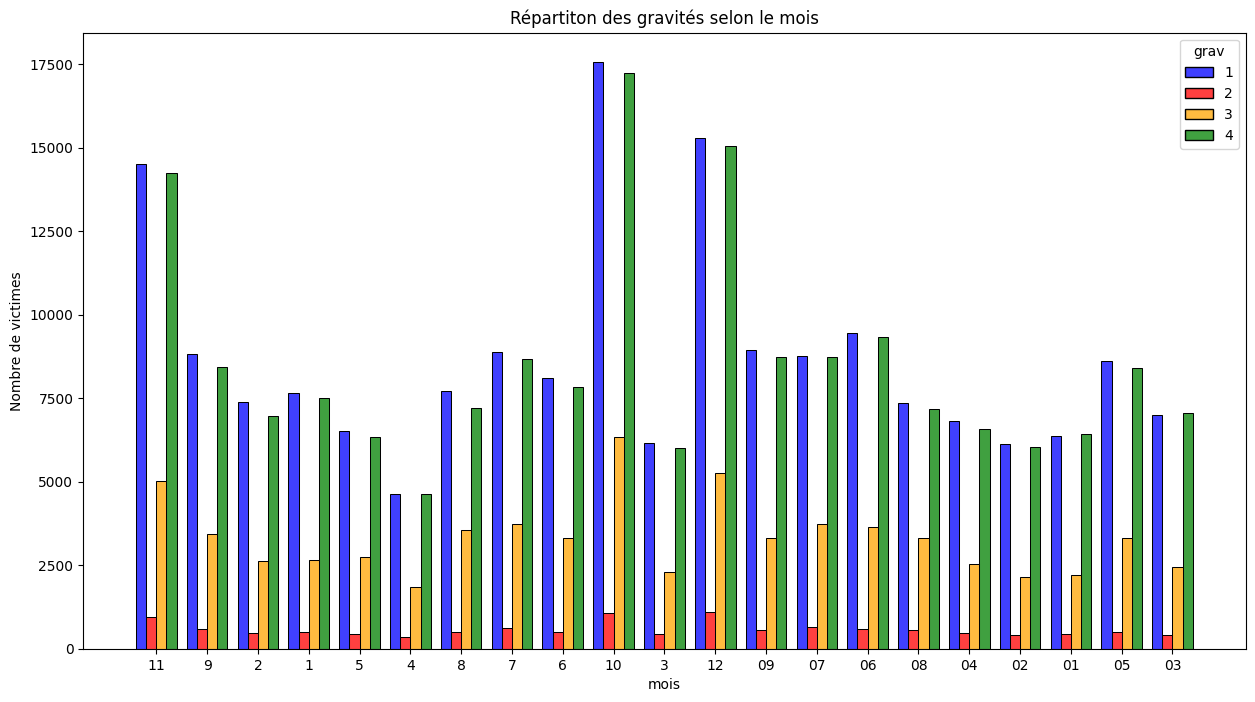

In [74]:
plt.figure(figsize=(15,8))
sns.color_palette("Paired")
palette = ['blue','green', 'orange','red']
        
sns.histplot(data=df, x='mois',  hue='grav', palette=palette, multiple='dodge', shrink =.8, order = 'mois')
plt.ylabel('Nombre de victimes')
plt.title('Répartiton des gravités selon le mois');

In [31]:
chi2_contingency(pd.crosstab(df['mois'], df['grav']))

Chi2ContingencyResult(statistic=np.float64(526.1483402944848), pvalue=np.float64(3.7209049978151205e-90), dof=33, expected_freq=array([[13952.23422478,   926.47409981,  5308.34921183, 13633.94246358],
       [13263.71883726,   880.75442054,  5046.39259214, 12961.13415006],
       [13121.39540485,   871.30367797,  4992.24338076, 12822.05753642],
       [11483.64460291,   762.55165478,  4369.1350643 , 11221.668678  ],
       [15216.64384894,  1010.43504466,  5789.41394482, 14869.50716158],
       [17656.35625264,  1172.43994772,  6717.64129583, 17253.56250381],
       [18077.55110624,  1200.40866703,  6877.89157067, 17665.14865606],
       [15446.83653093,  1025.72059351,  5876.99440844, 15094.44846712],
       [17660.89410121,  1172.74127574,  6719.36779243, 17257.99683062],
       [17419.15053195,  1156.6887101 ,  6627.3926102 , 17021.76814774],
       [14317.32476879,   950.71730901,  5447.25371059, 13990.70421162],
       [15131.2497895 ,  1004.76459912,  5756.92441799, 14786.0611933

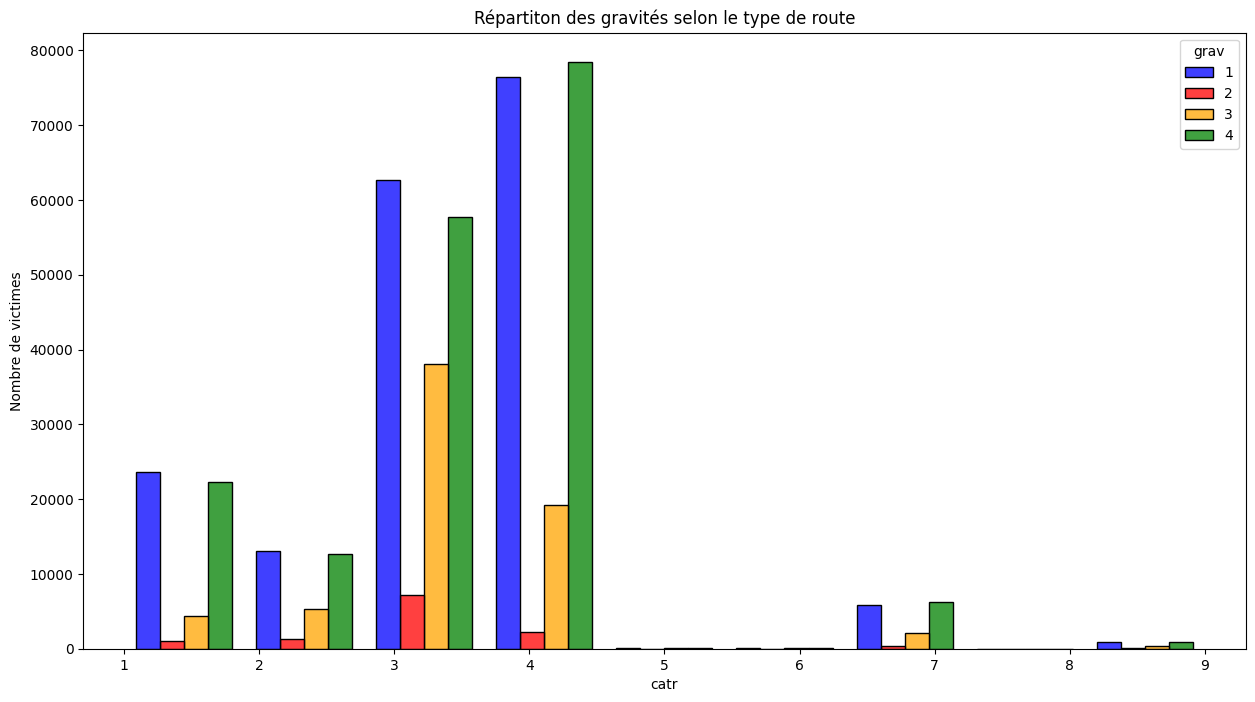

In [32]:
plt.figure(figsize=(15,8))
sns.color_palette("Paired")
palette = ['blue','green','orange','red']
        
#sns.displot(data=df, x='catr', kind='hist', hue='grav', palette=palette, multiple='dodge', bins=9, rwidth=0.7)
sns.histplot(data=df, x='catr',  hue='grav', palette=palette, multiple='dodge', bins=9, shrink=.8)
plt.ylabel('Nombre de victimes')
plt.title('Répartiton des gravités selon le type de route');

In [88]:
chi2_contingency(pd.crosstab(df['catr'], df['grav'])).pvalue

0.0

In [94]:
df.select_dtypes('int').columns

Index(['lum', 'int', 'atm', 'col', 'circ', 'nbv', 'vosp', 'prof', 'plan',
       'surf', 'infra', 'situ', 'vma', 'catv', 'obs', 'obsm', 'choc', 'manv',
       'motor', 'place', 'grav', 'sexe', 'trajet', 'secu_1', 'secu_2',
       'secu_3', 'secu_4', 'secu_5', 'secu_6', 'secu_7', 'secu_8', 'secu_9',
       'hh', 'weekend'],
      dtype='object')

In [95]:
[c for c in df.columns if c not in list(df.select_dtypes('int').columns) ]

['mois', 'agg', 'lat', 'long', 'catr', 'catu', 'classe_age']

In [96]:
df[['mois','agg','catr','catu','classe_age']] = df[['mois','agg','catr','catu','classe_age']].astype(int)

In [97]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 442989 entries, 0 to 494180
Data columns (total 41 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   mois        442989 non-null  int32  
 1   lum         442989 non-null  int32  
 2   agg         442989 non-null  int32  
 3   int         442989 non-null  int32  
 4   atm         442989 non-null  int32  
 5   col         442989 non-null  int32  
 6   lat         442989 non-null  float64
 7   long        442989 non-null  float64
 8   catr        442989 non-null  int32  
 9   circ        442989 non-null  int32  
 10  nbv         442989 non-null  int32  
 11  vosp        442989 non-null  int32  
 12  prof        442989 non-null  int32  
 13  plan        442989 non-null  int32  
 14  surf        442989 non-null  int32  
 15  infra       442989 non-null  int32  
 16  situ        442989 non-null  int32  
 17  vma         442989 non-null  int32  
 18  catv        442989 non-null  int32  
 19  obs    

In [98]:
df.to_csv('../Data/accidents.csv', index = False)